In [10]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.utils
import torch.autograd as autograd
import math
import torch.nn.functional as F
from tensorflow.keras.datasets import mnist

cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

def vis(y, nrow, title='figure'):
    imgs = torchvision.utils.make_grid(y, nrow=nrow, padding=0, normalize=True)

    if cuda:
        plt.imshow(imgs.permute(1, 2, 0).cpu())
    else:
        plt.imshow(imgs.permute(1, 2, 0))
    plt.title(title)
    plt.show()   
    
class Para():
    def __init__(self):
        self.latent_dim = 10 # latent space dimention
        self.img_shape = (1, 28, 28) # image shape (1x28x28 for MNIST)
        self.generator_path = 'G_l10_woBN.pth' # pre-trained generator path
        self.discriminator_path = 'D_l10_woBN.pth' # pre-trained discriminator path
        self.classifier_path = 'mnist_cnn.pt' # pre-trained classifier path
        self.batch_size = 25 # batch size for visualization
        self.gd_size = 100
        
opt = Para()

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=False):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(opt.latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(opt.img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], *opt.img_shape)
        return img

    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(opt.img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
    
# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()
# Initialize classifier
classifier = Net()


if cuda:
    generator.cuda()
    discriminator.cuda()
    classifier.cuda()
    
generator.load_state_dict(torch.load(opt.generator_path,map_location='cpu'))
discriminator.load_state_dict(torch.load(opt.discriminator_path,map_location='cpu'))
classifier.load_state_dict(torch.load(opt.classifier_path,map_location=torch.device('cpu')))

<All keys matched successfully>

In [14]:
# get data
def generate_data(gd_size,noise = False,a = 0.5):
    z = Variable(Tensor(np.random.normal(0, 1, (gd_size, opt.latent_dim)))) # latent variables
    if noise:
        eta = Variable(Tensor(np.random.normal(0, np.sqrt(a), (gd_size, *opt.img_shape)))) # noise (we need sqrt)
    with torch.no_grad():
        if noise:
            y = generator(z) + eta # generate images
        else:
            y = generator(z)
    output = classifier(y)
    tag = output.cpu().data.numpy().argmax(1)
    return y,tag,z

def get_mnist(gd_size):
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    # expand the channel dimension
    x_train = x_train.reshape(x_train.shape[0], 1,28, 28)
    x_test = x_test.reshape(x_test.shape[0], 1,28, 28)
    input_shape = (28, 28, 1)

    # make the value of pixels from [0, 255] to [0, 1] for further process
    x_train = x_train.astype('float32') / 255.
    x_test = x_test.astype('float32') / 255.
    index = np.random.choice(60000, gd_size)
    return x_train[index],y_train[index]

# Bootstrap PF

$\pi_{j}^{N}(v_{j}) \approx \sum_{n=1}^{N} w_{j}^{n} \delta (v_j-v_j^{(n)})$

In [749]:
def single_BootstrapPF(img,gd_size=100,J=5,noise = False):
    opt.gd_size = gd_size
    k = np.prod(opt.img_shape) #784
    d = opt.latent_dim #10
    N = opt.gd_size #10000
    a = 0.5
    H = np.hstack((np.zeros((k,d)),np.eye(k)))
    
    with torch.no_grad():
        y_gt = img # generated y from u_gt
        Y_gt = np.tile(y_gt.reshape(1,k),(N,1))

    u_0 = np.random.normal(0, 1, (opt.gd_size, opt.latent_dim))
    w_0 = np.random.normal(0, 1, (opt.gd_size, k))
    v_0 = np.transpose(np.hstack((u_0,w_0)))        
    v = v_0

    for j in range(J):
        with torch.no_grad():
            if noise:
                eta = np.random.normal(0, np.sqrt(a), (1, *opt.img_shape)) # noise (we need sqrt)
                Y = Y_gt + eta
                u = np.transpose(v[:d,:])
                w = generator(Variable(Tensor(u))).numpy().reshape((opt.gd_size,k))
                v = np.transpose(np.hstack((u,w)))
                tmp = Y-np.transpose(np.dot(H,v))
                weights = np.exp(-1/2*a*(np.linalg.norm(tmp,axis=1)**2))
                weights = weights/sum(weights)
            else:
                u = np.transpose(v[:d,:])
                w = generator(Variable(Tensor(u))).numpy().reshape((opt.gd_size,k))
                v = np.transpose(np.hstack((u,w)))
                tmp = Y_gt-np.transpose(np.dot(H,v))
                weights = np.exp(-1/2*(np.linalg.norm(tmp,axis=1)**2))
                weights = weights/sum(weights)
            if j == J-1:
                continue
            #sample
            index = np.random.choice(N,N,p = weights)
            v = v[:,index]
    return v[:d,:].transpose(),weights

def BootstrapPF(imgs,tag,gd_size=100,J=5,noise = False,data_type = 'mnist'):
    # imgs in shapes (N,np.prod(opt.img_shape))
    if data_type!='mnist':
        imgs = imgs.numpy()
    N = imgs.shape[0]
    #if np.dim(imgs)!=2:
    #    imgs = imgs.reshape((N,np.prod(opt.img_shape)))
    us = np.zeros((N,gd_size,opt.latent_dim))
    ws = np.zeros((N,gd_size))
    u_class = []
    w_class = []
    for i in range(N):
        u,w = single_BootstrapPF(imgs[i],gd_size=100,J=5,noise = False)
        us[i] = u
        ws[i] = w
    for i in range(10):
        index = np.where(tag==i)[0].tolist()
        u_tmp = us[index].reshape((gd_size*len(index),opt.latent_dim))
        w_tmp = ws[index].reshape((gd_size*len(index),))
        w_tmp = w_tmp/sum(w_tmp)
        u_class.append(u_tmp)
        w_class.append(w_tmp)
    return u_class,w_class

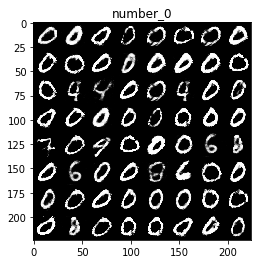

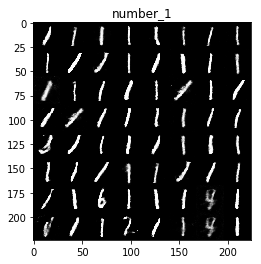

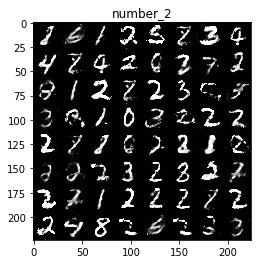

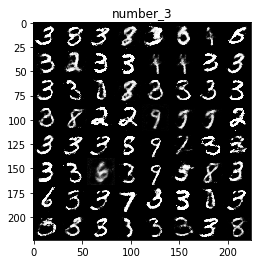

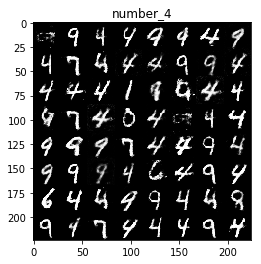

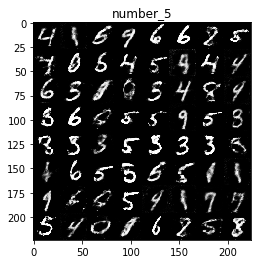

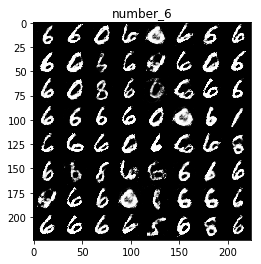

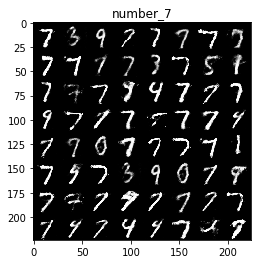

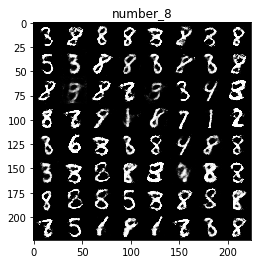

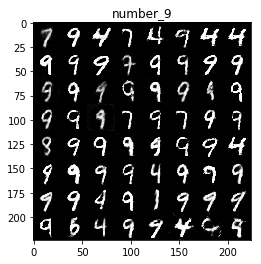

In [750]:
num_samples = 64
data_size = 1000
y,tag,l = generate_data(data_size,noise = False)
u_class,w_class = BootstrapPF(y,tag,gd_size=100,J=5,noise = False,data_type = 'generate')
for i in range(10):
    index = np.random.choice(u_class[i].shape[0],num_samples,p = w_class[i])
    z = Variable(Tensor(u_class[i][index]))
    with torch.no_grad():
        generated_imgs = generator(z) # generate images
        validity = discriminator(generated_imgs) # discriminator validaty
    vis(generated_imgs, nrow=int(np.sqrt(num_samples)),title = 'number_'+str(i))

# Gaussianized Optimal PF

In [21]:
def single_GOPF(img,gd_size=100,J=5,noise = False):
    opt.gd_size = gd_size
    k = np.prod(opt.img_shape) #784
    d = opt.latent_dim #10
    N = opt.gd_size #10000
    a = 0.5
    H = np.hstack((np.zeros((k,d)),np.eye(k)))
    
    with torch.no_grad():
        y_gt = img # generated y from u_gt
        Y_gt = np.tile(y_gt.reshape(1,k),(N,1))

    u_0 = np.random.normal(0, 1, (opt.gd_size, opt.latent_dim))
    w_0 = generator(Variable(Tensor(u_0))).detach().numpy().reshape((opt.gd_size,k))
    v_0 = np.transpose(np.hstack((u_0,w_0)))        
    v = v_0

    for j in range(J):
        with torch.no_grad():
            if noise:
                eta = np.random.normal(0, np.sqrt(a), (N, *opt.img_shape)) # noise (we need sqrt)
                Y = Y_gt + eta
                tmp = Y-np.transpose(np.dot(H,v))
                weights = np.exp(-1/2*a*(np.linalg.norm(tmp,axis=1)**2))
                weights = weights/sum(weights)
                index = np.random.choice(N,N,p = weights)
                v_hat = v[:,index]
                u = np.transpose(v_hat[:d,:])
                w = generator(Variable(Tensor(u))).numpy().reshape((opt.gd_size,k))
                v = np.transpose(np.hstack((u,w)))
                
            else:
                tmp = Y_gt-np.transpose(np.dot(H,v))
                weights = np.exp(-1/2*(np.linalg.norm(tmp,axis=1)**2))
                weights = weights/sum(weights)
                index = np.random.choice(N,N,p = weights)
                v_hat = v[:,index]
                u = np.transpose(v_hat[:d,:])
                w = generator(Variable(Tensor(u))).numpy().reshape((opt.gd_size,k))
                v = np.transpose(np.hstack((u,w)))            
    return v[:d,:].transpose()

def GOPF(imgs,tag,gd_size=100,J=5,noise = False,data_type = 'mnist'):
    # imgs in shapes (N,np.prod(opt.img_shape))
    if data_type!='mnist':
        imgs = imgs.numpy()
    N = imgs.shape[0]
    #if np.dim(imgs)!=2:
    #    imgs = imgs.reshape((N,np.prod(opt.img_shape)))
    us = np.zeros((N,gd_size,opt.latent_dim))
    u_class = []
    for i in range(N):
        u = single_BootstrapPF(imgs[i],gd_size=100,J=5,noise = False)
        us[i] = u
    for i in range(10):
        index = np.where(tag==i)[0].tolist()
        u_tmp = us[index].reshape((gd_size*len(index),opt.latent_dim))
        u_class.append(u_tmp)
    return u_class

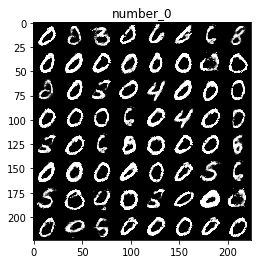

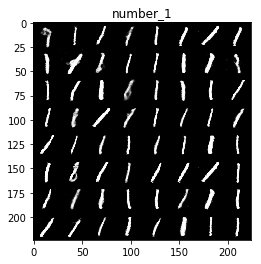

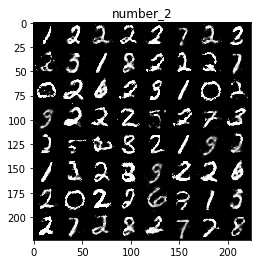

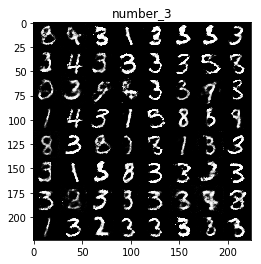

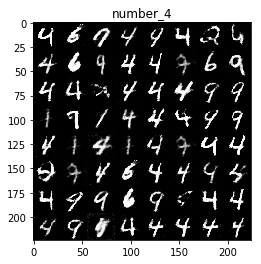

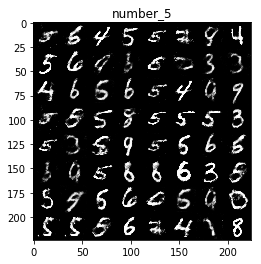

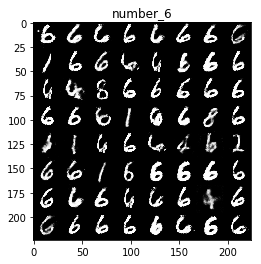

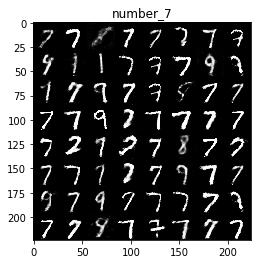

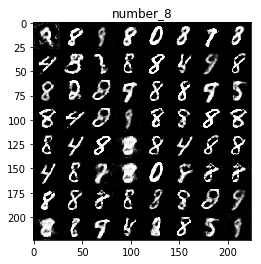

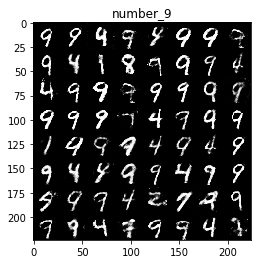

In [22]:
num_samples = 64
data_size = 1000
y,tag,l = generate_data(data_size,noise = False)
u_class = GOPF(y,tag,gd_size=100,J=5,noise = False,data_type = 'generate')
for i in range(10):
    index = np.random.choice(u_class[i].shape[0],num_samples)
    z = Variable(Tensor(u_class[i][index]))
    with torch.no_grad():
        generated_imgs = generator(z) # generate images
        validity = discriminator(generated_imgs) # discriminator validaty
    vis(generated_imgs, nrow=int(np.sqrt(num_samples)),title = 'number_'+str(i))

# Optimal PF (Linear)

In [640]:
from keras.datasets import mnist

# download and load the data (split them between train and test sets)
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# expand the channel dimension
x_train = x_train.reshape(x_train.shape[0], 1,28, 28)
x_test = x_test.reshape(x_test.shape[0], 1,28, 28)
input_shape = (28, 28, 1)

# make the value of pixels from [0, 255] to [0, 1] for further process
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

Using TensorFlow backend.


(60000, 1, 28, 28) (60000,)
(10000, 1, 28, 28) (10000,)


In [679]:
def OptPF(data,gd_size,J,a = 0.0001, b = 0.5,c = 0.1,data_type = 'mnist'):
    opt.gd_size = gd_size
    k = np.prod(opt.img_shape) #784
    d = opt.latent_dim #10
    N = opt.gd_size #100
    H = np.hstack((np.zeros((k,d)),np.eye(k)))#784x794
    Sita = a * np.eye(k+d) #794x794
    Gamma = b * np.eye(k) #784x784
    S = np.matmul(np.matmul(H,Sita),H.transpose())+Gamma #784x784
    K = np.matmul(np.matmul(Sita,H.transpose()),np.linalg.inv(S)) #794x784
    with torch.no_grad():
        if data_type == 'mnist':
            Y_gt = data.reshape(N, k)
        else:
            Y_gt = data.numpy().reshape(N, k)
    u_0 = np.random.normal(0, 1, (opt.gd_size, opt.latent_dim))
    w_0 = np.random.normal(0, 1, (opt.gd_size, k))
    v_0 = np.transpose(np.hstack((u_0,w_0)))        
    v = v_0 # 794x100
    for j in range(J):
        with torch.no_grad():
            eta = np.random.normal(0, np.sqrt(b), (N, k)) #100x784
            Y = Y_gt+eta
            u = np.transpose(v[:d,:]) #100x10
            w = generator(Variable(Tensor(u))).numpy().reshape((opt.gd_size,k)) #100x784
            f_v = np.transpose(np.hstack((u,w))) #794x100
            ci = np.random.normal(0, np.sqrt(c), (k+d, N)) #794x100
            #print(K.shape,H.shape,f_v.shape,Y.shape)
            v_hat = np.matmul((np.eye(k+d)-np.matmul(K,H)),f_v)+np.matmul(K,Y.transpose())+ci #794x100
            tmp = Y-np.transpose(np.dot(H,v))#100x784
            weights = np.exp(-1/2*b*(np.linalg.norm(tmp,axis=1)**2)) #(100,)
            #weights = np.exp(-1/2*np.matmul(np.matmul(tmp,np.linalg.inv(S)),tmp.transpose()).diagonal()) #(100,)
            weights = weights/sum(weights)#(100,)
            #resampling
            r = np.zeros((N,N))
            for i in range(N):
                r[i,:] =np.random.choice(2,N,p=[1-weights[i],weights[i]])
            v = np.matmul(v_hat,r)
    return v[:d,:].transpose()#100x10

In [751]:
def OptPF(data,gd_size,J,b = 0.5,c = 0.1,data_type = 'mnist'):
    opt.gd_size = gd_size
    k = np.prod(opt.img_shape) #784
    d = opt.latent_dim #10
    N = opt.gd_size #100
    H = np.hstack((np.zeros((k,d)),np.eye(k)))#784x794
    S = b * np.eye(k) #784x784
    with torch.no_grad():
        if data_type == 'mnist':
            Y_gt = data.reshape(N, k)
        else:
            Y_gt = data.numpy().reshape(N, k)
    u_0 = np.random.normal(0, 1, (opt.gd_size, opt.latent_dim))
    w_0 = np.random.normal(0, 1, (opt.gd_size, k))
    v_0 = np.transpose(np.hstack((u_0,w_0)))        
    v = v_0 # 794x100
    for j in range(J):
        with torch.no_grad():
            #eta = np.random.normal(0, np.sqrt(b), (N, k)) #100x784
            #Y = Y_gt+eta
            Y = Y_gt
            u = np.transpose(v[:d,:]) #100x10
            w = generator(Variable(Tensor(u))).numpy().reshape((opt.gd_size,k)) #100x784
            f_v = np.transpose(np.hstack((u,w))) #794x100
            ci = np.random.normal(0, np.sqrt(c), (k+d, N)) #794x100
            #print(K.shape,H.shape,f_v.shape,Y.shape)
            #v_hat = f_v+ci #794x100
            v_hat = f_v
            tmp = Y-np.transpose(np.dot(H,v))#100x784
            weights = np.exp(-1/2*b*(np.linalg.norm(tmp,axis=1)**2)) #(100,)
            #weights = np.exp(-1/2*np.matmul(np.matmul(tmp,np.linalg.inv(S)),tmp.transpose()).diagonal()) #(100,)
            weights = weights/sum(weights)#(100,)
            #resampling
            v =v_hat[:,np.random.choice(N,N,p=weights)]
    return v[:d,:].transpose()#100x10

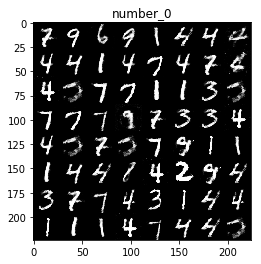

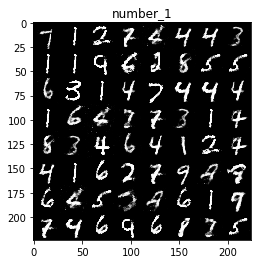

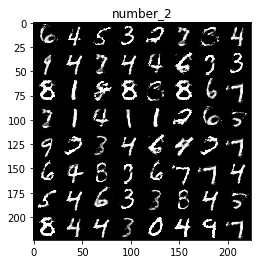

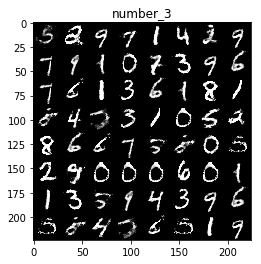

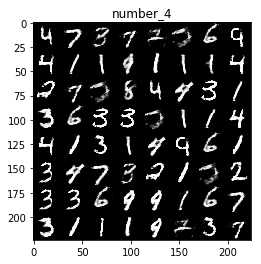

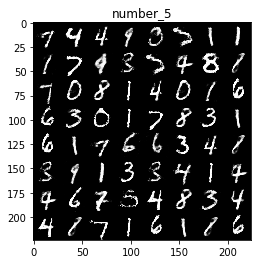

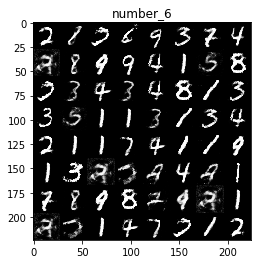

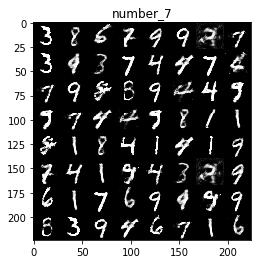

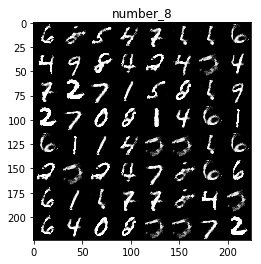

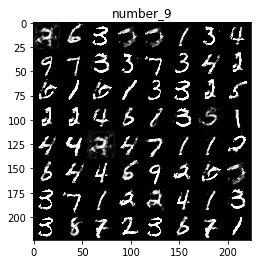

In [754]:
num_samples = 64
opt.gd_size = 500
data_size = 1000
J = 3
y,tag,l = generate_data(opt.gd_size,noise = True)
u = OptPF(y,opt.gd_size,J,b = 0.01,c = 0.0001,data_type = 'generate')
#print(u)
u_class = []
for i in range(10):
    mask = np.equal(tag,i)
    tmp = u[mask]
    u_class.append(tmp)
for i in range(10):
    index = np.random.choice(u_class[i].shape[0], num_samples)
    samples = u_class[i][index]
    z = Variable(Tensor(samples)) # latend variables

    with torch.no_grad():
        generated_imgs = generator(z) # generate images
        validity = discriminator(generated_imgs) # discriminator validaty

    vis(generated_imgs, nrow=int(np.sqrt(num_samples)),title = 'number_'+str(i))

# EKI for distribution

$\pi_{j}^{N}(v_{j}) \approx \frac{1}{N}\sum_{n=1}^{N} \delta (v_j-v_j^{(n)})$

In [629]:
#EKF for distribution
def EnKI(data,gd_size,J,a = 0.5, data_type = 'mnist',noise = False):
    opt.gd_size = gd_size
    k = np.prod(opt.img_shape)
    d = opt.latent_dim
    N = opt.gd_size
    Gamma = a * np.eye(k)
    
    with torch.no_grad():
        if data_type=='mnist':
            y_gt = data
        else:
            y_gt = data.numpy() # generated y from u_gt
         # generated y from u_gt
        Y_gt = y_gt.reshape(N, k)
        
    u_0 = np.random.normal(0, 1, (opt.gd_size, opt.latent_dim))
    U = np.zeros((J+1, N, opt.latent_dim))
    U[0, :, :] = u_0
    u = u_0

    for j in range(J):
        with torch.no_grad():
            if noise:
                eta = np.random.normal(0, np.sqrt(a), (N, k)) # noise (we need sqrt)
                Y = Y_gt + eta
            else:
                Y = Y_gt
            u_bar = np.mean(u, 0).reshape(d, 1)
            G = generator(Tensor(u)).numpy().reshape(N, k)
            G_bar = np.mean(G, 0).reshape(k, 1)
            u_stack = u.transpose() - u_bar @ np.ones((1, N))
            G_stack = G - np.ones((N, 1)) @ G_bar.transpose()
            C_uw = 1/N * u_stack @ G_stack
            C_ww = 1/N * G_stack.transpose() @ G_stack
            u_tran = u.transpose() + C_uw @ np.linalg.inv(C_ww + Gamma) @ (Y - G).transpose()
            u = u_tran.transpose()        
            U[j+1, :, :] = u
    return u

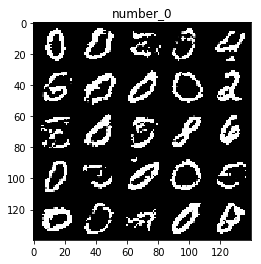

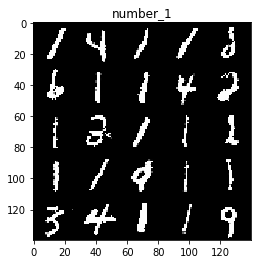

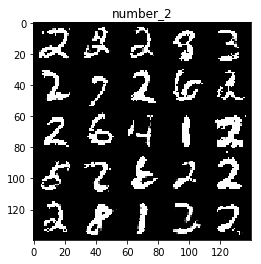

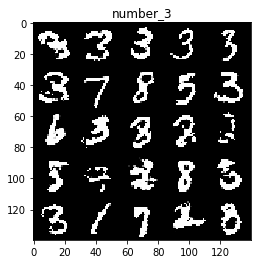

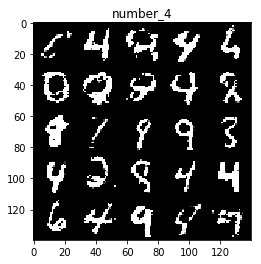

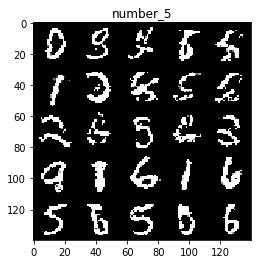

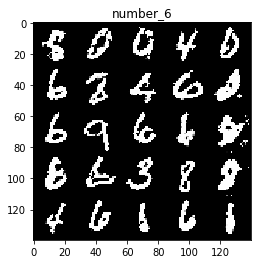

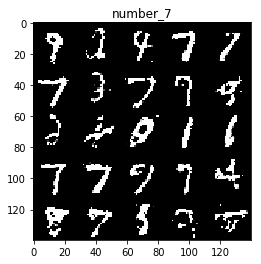

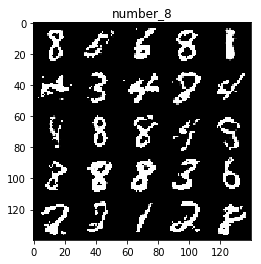

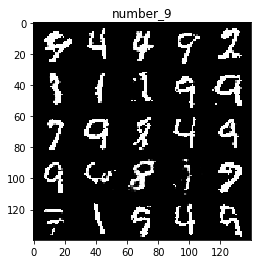

In [630]:
num_samples = 25
opt.gd_size = 60000
J = 20
y,tag,l = generate_data(opt.gd_size,noise = True)
u = EnKI(y,opt.gd_size,J,data_type = 'generate')
u_class = []
for i in range(10):
    mask = np.equal(tag,i)
    tmp = u[mask]
    u_class.append(tmp)
for i in range(10):
    index = np.random.choice(u_class[i].shape[0], num_samples)
    samples = u_class[i][index]
    z = Variable(Tensor(samples)) # latend variables

    with torch.no_grad():
        generated_imgs = generator(z) # generate images
        validity = discriminator(generated_imgs) # discriminator validaty

    vis(generated_imgs, nrow=int(np.sqrt(opt.batch_size)),title = 'number_'+str(i))